In [1]:
import ast
from collections import deque
import numpy as np
import networkx as nx
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

2025-04-10 16:11:54.677 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:12 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


True

In [ ]:
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")
df_eth_balances_class0 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class0.csv")
df_eth_balances_class1 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class1.csv")

In [3]:
df_eth_balances_class1.rename(
    columns={"account": "from", "block_number": "blockNumber", "balance": "eth_balance"},
    inplace=True,
)
df_eth_balances_class0.rename(
    columns={"account": "from", "block_number": "blockNumber", "balance": "eth_balance"},
    inplace=True,
)
df_eth_balances_class1.head()

,from,blockNumber,eth_balance
0,0x758E8229Dd38cF11fA9E7c0D5f790b4CA16b3B16,17157648,8646277360479316600
1,0x758E8229Dd38cF11fA9E7c0D5f790b4CA16b3B16,17186695,8633925972872452145
2,0x23583b8104C11F3C2fB30Cee228170FcffAaD0b2,17292456,1305917357146785935
3,0xb5eaaC5a8649142dcDd13F981767913bcDF7ee42,16999810,7913546026418846113
4,0x4dD36C49B200A6d52eBB365F01Bf0e4Db8b9f765,17451383,5737284614201392416


In [4]:
df_eth_balances_class0 = df_eth_balances_class0.set_index(["from", "blockNumber"])
df_eth_balances_class1 = df_eth_balances_class1.set_index(["from", "blockNumber"])

In [5]:
df_eth_balances_class1.head(50)

eth_balance
from                                       blockNumber                      
0x758E8229Dd38cF11fA9E7c0D5f790b4CA16b3B16 17157648      8646277360479316600
                                           17186695      8633925972872452145
0x23583b8104C11F3C2fB30Cee228170FcffAaD0b2 17292456      1305917357146785935
0xb5eaaC5a8649142dcDd13F981767913bcDF7ee42 16999810      7913546026418846113
0x4dD36C49B200A6d52eBB365F01Bf0e4Db8b9f765 17451383      5737284614201392416
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 17392128      4430209405636388821
                                           17274435      8792964667683797617
0x0124D0fA0DfB1430dFcff16eC6A96945E7a0BC10 17219132     38155942328329329878
0x758E8229Dd38cF11fA9E7c0D5f790b4CA16b3B16 17231957      8953039789386900853
0x6ecE2367Fe06cBf5890cb60a73FdE945D61F5361 17243525       108622955896127075
0x0Fb153696A35B2C9A2d7B5bCec1788e331086192 17186784       508705375166687036
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 17456638      6134194117648759786
0x28341B173178E37f0Cd2A5B35A09A60d70c6f12C 17347860      2451014311915483757
0x3001f6F2187D875a1Bc24B10Fe9616Ebcaf4fB45 17378804      2673973411115052095
0x00000006e42915A2B6907f8b3fAF311B68862f60 17303725       175758814978554361
0x8C6Bb9b846fd74CbCf0EAD7F90beacd906A73A9b 17153131       594030844037198931
0x869981574213fe29d86d4BA74B7Ff43E184e70AF 17304521       213346150961551713
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 17306865      7787404192647084107
0xA30622a0061513B1B6971307b66E8ba4c4F52f3c 17397965     23805287966925682600
0x19e4A1C4095c90800afE8DF09512E361755BC161 17070145       382543598640972804
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 17495484     12181284109196194059
0x000000a010FBFEA4c98cff39C9CcC6f7A9D70906 17245003      1380431487519738254
0xd7E1236C08731C3632519DCd1A581bFe6876a3B2 17297639      1220172044271783524
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 16997520     14568696287741200159
0x23583b8104C11F3C2fB30Cee228170FcffAaD0b2 17073635      1057196401183958328
0xb8feFFAC830C45b4Cd210ECDAAB9D11995D338ee 17451344      9789812199679605327
0x0000e0C70000ca6bc5006838e7cc3e7C8fD23D00 17038776      1974213394724764308
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 17166891      2423064619937361448
                                           17368342      7405378244295034576
                                           17320047     10691389764399345828
0xd3EB99dbB20Ad11D5AB40D59f86c7CA3e1f00293 17380488      3000183820511919710
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 17205737      1351804809225101356
0x1264F83b093abbF840eA80a361988D19C7f5a686 17394572     14109512123178845826
0x7b2C841Ed85C5997713aDd9b523423aCA5Cdd796 17121516      2718472542526053282
0x00000006e42915A2B6907f8b3fAF311B68862f60 17336505      1183091556564979198
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 17068796      1748258927061296432
0xB28eBE0eD76E01825483A723d21A6Ab29743cdDC 17448838       311230245621117712
0x3AB1532160487E11d7C19b8492fb01b7b895Db43 17347216      1472097557411115603
0x3001f6F2187D875a1Bc24B10Fe9616Ebcaf4fB45 17463262       655525104903121802
0x28341B173178E37f0Cd2A5B35A09A60d70c6f12C 17425902      1056233164134612267
                                           17148637      1749107517164023317
0x37799298e3fbbD9475737aaE2Af8fB872A3bECa2 17043286       728292594790030312
0x76F36d497b51e48A288f03b4C1d7461e92247d5e 17117441      1187777857944773383
                                           17028795      2481324334849112676
                                           17022379      2806838758541895446
0xb9Fa59CA6C777E0C635148EDaa74BaAf6b0EAD83 17138692      1243173972495665178
0x758E8229Dd38cF11fA9E7c0D5f790b4CA16b3B16 16986317      3027024634808510490
0x23583b8104C11F3C2fB30Cee228170FcffAaD0b2 17327464      2308124092815955125
0x7594F15D27B58C04B82C3891e6f5f4488b2006e0 17358439     14416004117266249230
0x27F3a1d082005D5B32a091718E2613c8b0e92658 17348663      1832628139847272404

In [6]:
df_class0_with_eth_balances = df_class0.join(
    df_eth_balances_class0, on=["from", "blockNumber"], how="inner"
)
df_class1_with_eth_balances = df_class1.join(
    df_eth_balances_class1, on=["from", "blockNumber"], how="inner"
)

In [7]:
df_class0_multi_occ = df_class0_with_eth_balances[
    df_class0_with_eth_balances["from"].duplicated(keep=False)
]
df_class0_multi_occ_clean = df_class0_multi_occ.dropna(subset=["from", "to"])

In [8]:
df_class0_multi_occ_clean.head()

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,to,type,effectiveGasPrice,logs,status,eth_balance
1,16950601,0x5f7a16727b0ed026b1656924be454df15951fc3d1350...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00000000000000000000000000000000000000000000...,21000,NaN,4567366,57,0x8216874887415e2650D12D53Ff53516F04a74FD7,0x644b349BB829393d80Fc9120572b87fdDD5BCC4f,2,19361969611,[],1,19509521415458382857
4,16950601,0x7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00000000000000000000000000000000000000000000...,48537,NaN,10131517,140,0x4E5B2e1dc63F6b91cb6Cd759936495434C7e972F,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0,22000000000,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,1,911549369427104094147
15,16950601,0xaf94feedf4330e4a5c2bf084d2e6739652287dbfc6e0...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00000000000000000000000000000000000000000000...,254032,NaN,2564577,16,0xC6c7565644EA1893ad29182F7B6961AAb7EDFeD0,0xA88800CD213dA5Ae406ce248380802BD53b47647,2,22568554601,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,1,5054009568558988368
16,16950601,0xce78f60252b7738dc4b4800fcbd1959d4c4a7d8c9169...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00000000000000000000000000000000000000000000...,21000,NaN,2310545,15,0x5455120540843dce9D54327069b62D2593E209A9,0xe478b7f86104A77C729eD059199375C1f73765f6,2,25081861693,[],1,0
22,16950602,0x68e0bdc91e3c74a4cef9e3a7875c284183da92067c42...,0xb7b27a4871eba9cd96bf6b2704b2f67a8b56565c93e3...,16950602,0x00000000008000000000000000020000000000000000...,46097,NaN,390165,6,0x46340b20830761efd32832A74d7169B29FEB9758,0xdAC17F958D2ee523a2206206994597C13D831ec7,0,29574843255,[{'blockHash': '0xb7b27a4871eba9cd96bf6b2704b2...,1,14410892606951780426896


In [53]:
def extract_transfer_addresses(topics):
    from_address = "0x" + topics[1][-40:]
    to_address = "0x" + topics[2][-40:]
    return from_address, to_address

In [54]:
def create_group_transaction_graph(group_df, label):
    group_account_mapping = {}
    group_balances = {}
    node_counter = 0
    cumulative_edges = []
    cumulative_edge_attrs = []
    graphs = []

    for _, row in group_df.iterrows():
        from_addr_main, to_addr_main = row["from"].lower(), row["to"].lower()
        if from_addr_main not in group_account_mapping:
            group_account_mapping[from_addr_main] = node_counter
            node_counter += 1
        if to_addr_main not in group_account_mapping:
            group_account_mapping[to_addr_main] = node_counter
            node_counter += 1
        cumulative_edges.append(
            [group_account_mapping[from_addr_main], group_account_mapping[to_addr_main]]
        )

        if from_addr_main not in group_balances:
            group_balances[from_addr_main] = {}

        if to_addr_main not in group_balances:
            group_balances[to_addr_main] = {}

        ethereum_placeholder_addr = "0x0000000000000000000000000000000000000000"
        if ethereum_placeholder_addr not in group_balances[from_addr_main]:
            amount = int(row["eth_balance"])
            group_balances[from_addr_main][ethereum_placeholder_addr] = (
                np.sign(amount) * np.log1p(np.abs(float(amount))) if amount != 0 else 0
            )

        logs = ast.literal_eval(row["logs"])
        for log in logs:
            log_address = log["address"]
            topics = log["topics"]

            ERC20_TRANSFER_SIG = (
                "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
            )

            if not topics or topics[0] != ERC20_TRANSFER_SIG or len(topics) < 3:
                continue

            from_addr, to_addr = extract_transfer_addresses(topics)
            if from_addr not in group_balances:
                group_balances[from_addr] = {}
            if to_addr not in group_balances:
                group_balances[to_addr] = {}

            amount = int(log["data"], 16) if log["data"] != "0x" else 0
            if log_address not in group_balances[from_addr]:
                group_balances[from_addr][log_address] = 0
            if log_address not in group_balances[to_addr]:
                group_balances[to_addr][log_address] = 0
            group_balances[from_addr][log_address] -= (
                np.sign(amount) * np.log1p(np.abs(float(amount))) if amount != 0 else 0
            )
            group_balances[to_addr][log_address] += (
                np.sign(amount) * np.log1p(np.abs(float(amount))) if amount != 0 else 0
            )

            if from_addr not in group_account_mapping:
                group_account_mapping[from_addr] = node_counter
                node_counter += 1
            if to_addr not in group_account_mapping:
                group_account_mapping[to_addr] = node_counter
                node_counter += 1

            cumulative_edges.append(
                [group_account_mapping[from_addr], group_account_mapping[to_addr]]
            )

        num_nodes = node_counter
        degree = [0] * num_nodes
        for src, dst in cumulative_edges:
            degree[src] += 1
            degree[dst] += 1
        degree = torch.tensor(degree, dtype=torch.float).unsqueeze(1)

        # --- Add balances to the node features ---
        # Create a reverse mapping: node id -> account address.
        reverse_mapping = {v: k for k, v in group_account_mapping.items()}
        # Determine all tokens seen in the balances (fixed order).
        all_tokens = sorted({token for bal in group_balances.values() for token in bal.keys()})
        node_features = []
        for i in range(num_nodes):
            account = reverse_mapping[i]
            # Start with the node's degree.
            deg = degree[i].item()
            # Get the balance dictionary for this account (if any) and produce a vector.
            balances = group_balances.get(account, {})
            token_features = [balances.get(token, 0) for token in all_tokens]
            # Concatenate degree with balance features.
            node_features.append([deg] + token_features)

        node_features_tensor = torch.tensor(node_features, dtype=torch.float)

        edge_index_tensor = torch.tensor(cumulative_edges, dtype=torch.long).t().contiguous()
        edge_attr_tensor = torch.tensor(cumulative_edge_attrs, dtype=torch.int)

        y = torch.tensor(label, dtype=torch.int)
        trx_id = row["transaction_hash"]
        block_number = row["blockNumber"]
        from_addr = row["from"].lower()

        data = Data(
            x=node_features_tensor, y=y, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor
        )
        data.account_mapping = group_account_mapping.copy()
        data.trx_id = trx_id
        data.block_number = block_number
        data.from_addr = from_addr
        graphs.append(data)

    return graphs

In [55]:
# # Group transactions by the from_account and build graphs for each group.
# grouped_data = []
# for account, group_df in df_example_acc.groupby("account_address"):
#     grouped_data.append(create_group_transaction_graph(group_df, 1))

In [70]:
grouped_data0 = {}
window_size = 10

for account, group_df in df_class0_multi_occ_clean.groupby("from"):
    sliding_graphs = []
    window_rows = deque(maxlen=window_size)
    for _, row in group_df.iterrows():
        window_rows.append(row)
        window_df = pd.DataFrame(list(window_rows))
        current_snapshot = create_group_transaction_graph(window_df, label=0)[-1]
        sliding_graphs.append(current_snapshot)
    grouped_data0[account] = sliding_graphs

In [61]:
grouped_data1 = {}
window_size = 10

for account, group_df in df_class1_with_eth_balances.groupby("from"):
    sliding_graphs = []
    window_rows = deque(maxlen=window_size)
    for _, row in group_df.iterrows():
        window_rows.append(row)
        window_df = pd.DataFrame(list(window_rows))
        current_snapshot = create_group_transaction_graph(window_df, label=1)[-1]
        sliding_graphs.append(current_snapshot)
    grouped_data1[account] = sliding_graphs

In [71]:
grouped_data = grouped_data0 | grouped_data1

In [72]:
grouped_data["0x00000000000124d994209fbB955E0217B5C2ECA1"][1].trx_id

'0xbcfb84169287cf7acce33fba2b7390cfe21852871f78851fcf3f3a4cb9c34349'

In [73]:
grouped_data["0x00000000000124d994209fbB955E0217B5C2ECA1"][2].x

tensor([[  4.0000,  40.2402, -51.7854,   0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000],
        [  3.0000,   0.0000,   0.0000,  41.6617],
        [  2.0000,   0.0000,  51.7854, -41.6617]])

In [74]:
grouped_data["0x4f164C12934500ff43d61Db950CA7eCa53162604"][0].account_mapping

{'0x4f164c12934500ff43d61db950ca7eca53162604': 0,
 '0xfd0000000100069ad1670066004306009b487ad7': 1,
 '0xe34947aaaff202e2f08bd8b05f550b868c7383d4': 2,
 '0x844146b6a5318cacbc059505a42ff5f21afe9fa1': 3}

In [77]:
grouped_data["0x0000000000055772357E58581A2A2C5C6D9E8F64"][50].edge_index

tensor([[ 0,  2,  3,  1,  0,  4,  1,  5,  0,  4,  1,  5,  0,  6,  1,  7,  0,  8,
          9,  1,  0, 10,  1, 11,  0, 12, 13,  1,  0,  4,  1,  5,  0,  4,  1,  5,
          0,  8,  9,  1],
        [ 1,  1,  2,  3,  1,  1,  5,  4,  1,  1,  5,  4,  1,  1,  7,  6,  1,  1,
          8,  9,  1,  1, 11, 10,  1,  1, 12, 13,  1,  1,  5,  4,  1,  1,  5,  4,
          1,  1,  8,  9]])

In [27]:
def visualize_graph(G, color):
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    nx.draw_networkx_nodes(G, pos, node_color=color, cmap="Set2")
    nx.draw_networkx_edges(G, pos)

    # labels = {node: str(G.nodes[node].get("x", "")) for node in G.nodes()}
    # nx.draw_networkx_labels(G, pos, labels=labels)

    plt.show()

/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


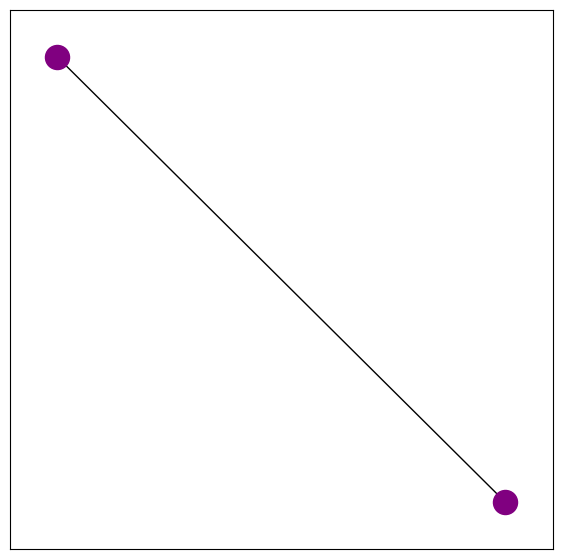

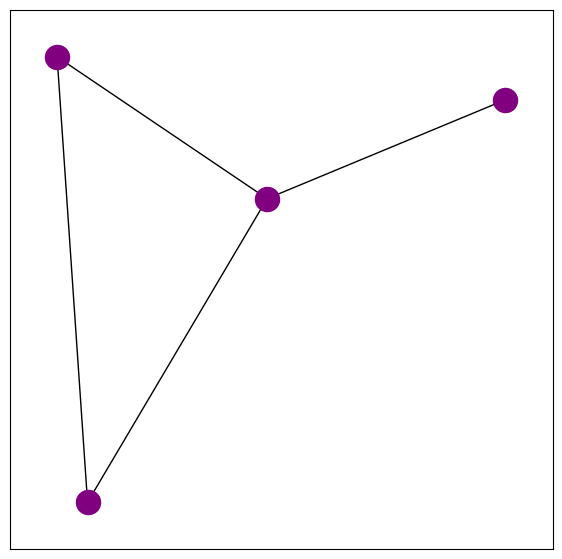

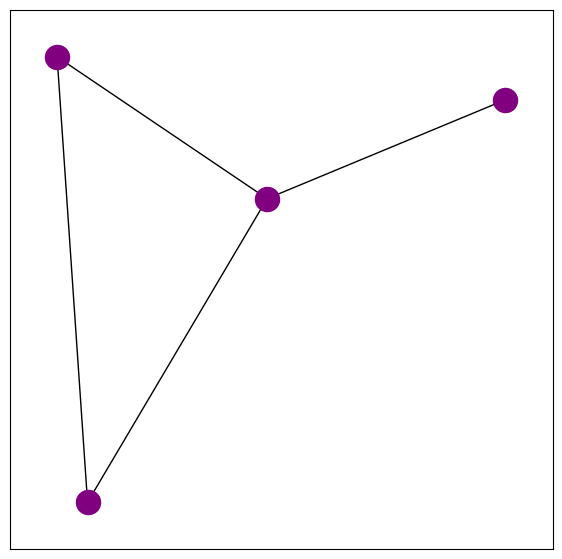

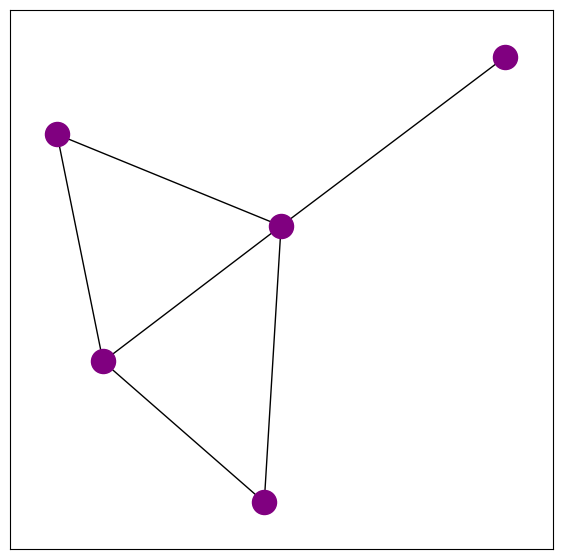

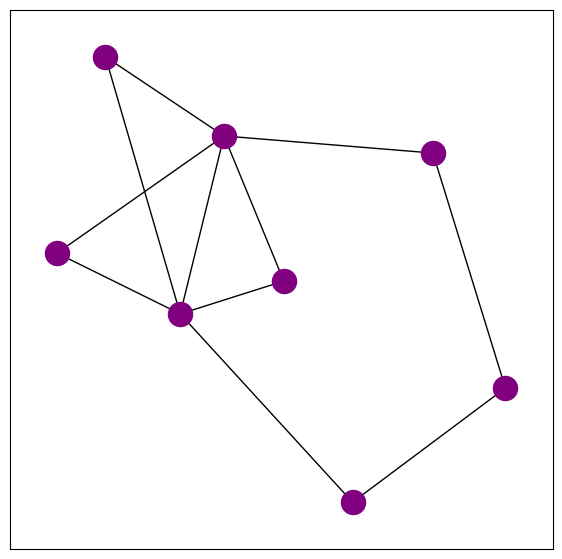

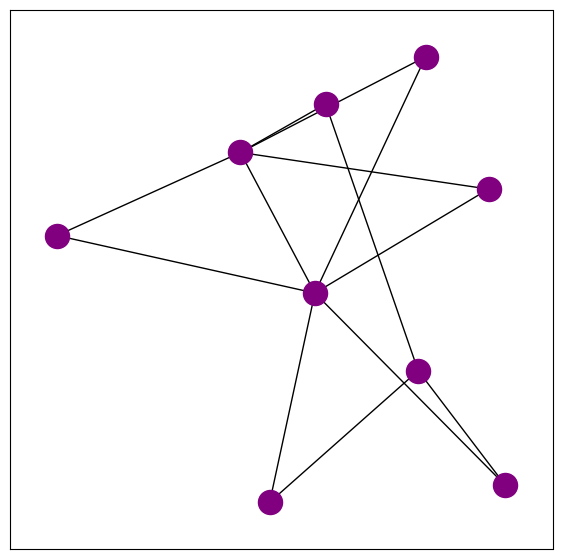

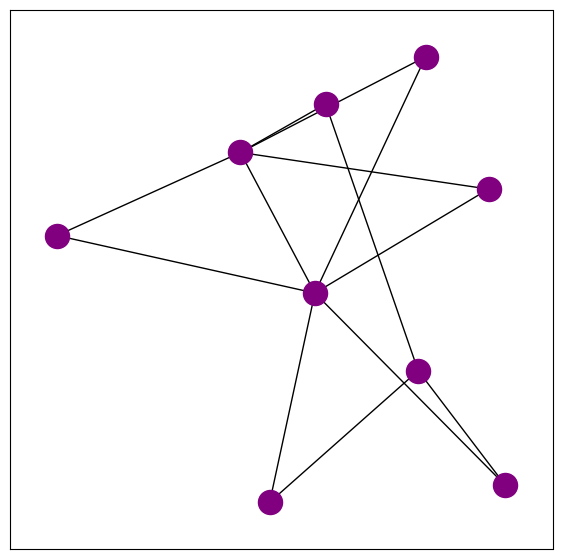

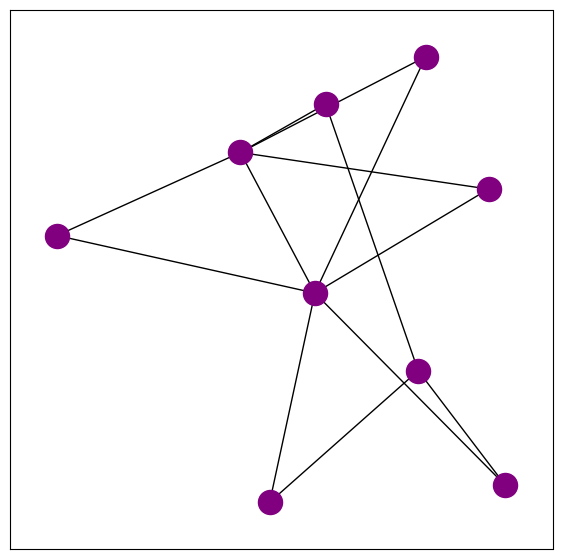

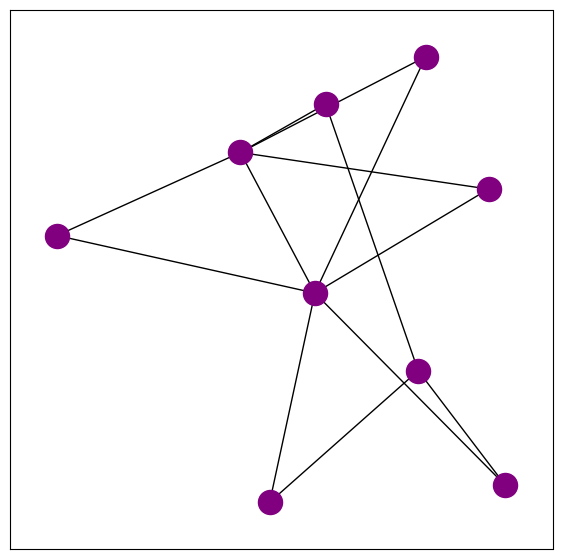

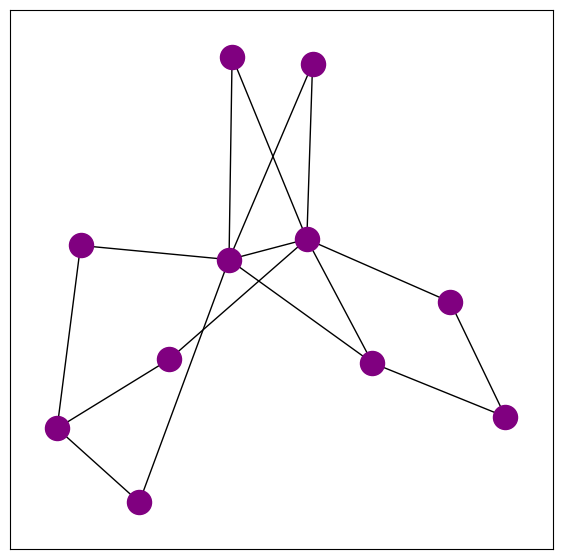

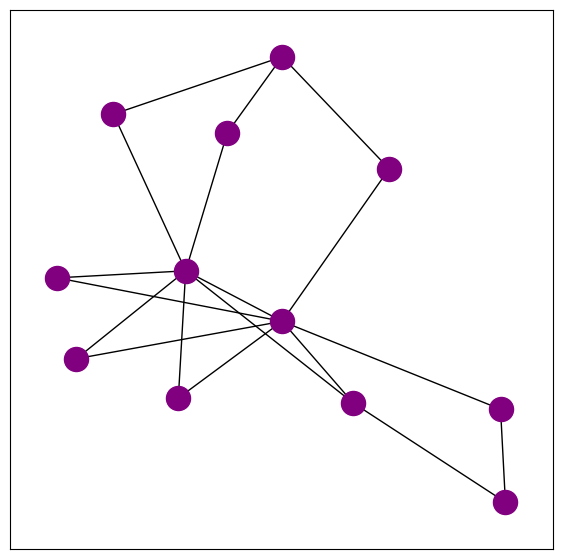

In [78]:
for d in grouped_data["0x00000000000124d994209fbB955E0217B5C2ECA1"]:
    G = to_networkx(
        d,
        node_attrs=["x"],
        # edge_attrs=["edge_attr"],
        to_undirected=True,
    )
    visualize_graph(G, color="purple")

In [79]:
torch.save(grouped_data, config.FLASHBOTS_Q2_DATA_DIR / "state_graphs.pt")